# Notebook for reproducing Fig 6 second part (chirality) and S10-S11

In [1]:
import concurrent.futures
from multiprocessing import Pool
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import rotate
from tqdm.auto import tqdm

from mbhl import *

In [2]:
%mkdir -p subfigs-Fig6b

The following functions are used to plot the n=3 and n=4 deposition for square and hexagonal, respectively

In [15]:
def plot_3P_deposition(
    ax=None,
    rl_ratio=0.25,
    Rl_ratio=0.5,
    theta=0.0,
    L=500 * nm,
    H=5 * um,
    diffusion=10 * nm,
    default_h=5 * nm,
    default_alpha=1.0,
    drift=0 * nm,
    gap=2.5 * um,
    cmap="viridis",
    alpha=1.0,
    h_ratio=1.0,
    n_pts=3,
    repeat=10,
):
    radius = L * rl_ratio
    R = L * Rl_ratio
    W = L * np.sqrt(3)
    phi = np.arctan(R / H / 2)

    n_pts = n_pts
    trajectory = n_beam_trajectory(phi, theta_0=theta, n_pts=n_pts)
    phys = Physics(trajectory, diffusion=diffusion, drift=drift)
    geom = honeycomb_hole_lattice(radius, L, orientation="vertical")
    stencil = Stencil(geom, thickness=0, gap=H, h=default_h / h_ratio)
    system = System(stencil=stencil, physics=phys)
    conv = system.simulate(method="fft", fold_to_bz=False)
    if ax is not None:
        ax.set_axis_off()
        system.draw(
            ax=ax,
            mask_alpha=1.0,
            show_mask=False,
            cmap=cmap,
            mask_lw=0,
            domain=[W, (repeat - 1) * W, W, (repeat - 1) * W],
            alpha=alpha,
        )
    return system

In [16]:
def plot_4P_deposition(
    ax=None,
    rl_ratio=0.25,
    Rl_ratio=0.5,
    theta=0.0,
    L=500 * nm,
    H=5 * um,
    diffusion=15 * nm,
    default_h=5 * nm,
    default_alpha=1.0,
    drift=0 * nm,
    gap=2.5 * um,
    cmap="viridis",
    alpha=1.0,
    h_ratio=1.0,
    n_pts=4,
    repeat=10,
):
    radius = L * rl_ratio
    R = L * Rl_ratio
    phi = np.arctan(R / H / 2)
    trajectory = n_beam_trajectory(phi, theta_0=theta, n_pts=n_pts)
    phys = Physics(trajectory, diffusion=diffusion, drift=drift)
    W = L
    geom = square_hole_lattice(radius, L)
    stencil = Stencil(geom, thickness=0, gap=H, h=default_h / h_ratio)
    system = System(stencil=stencil, physics=phys)
    conv = system.simulate(method="fft", fold_to_bz=False)
    if ax is not None:
        ax.set_axis_off()
        system.draw(
            ax=ax,
            mask_alpha=1.0,
            show_mask=False,
            cmap=cmap,
            mask_lw=0,
            domain=[W, (repeat - 1) * W, W, (repeat - 1) * W],
            alpha=alpha,
        )
    return system

In [13]:
def gen_zmesh_pn(
    rl_ratio=0.25,
    Rl_ratio=0.5,
    theta=0.0,
    repeat=1,
    default_h=10 * nm,
    method=plot_3P_deposition,
):
    """Generate the mesh between positive and negative mesh"""
    # Positive
    system_p = method(
        ax=None,
        rl_ratio=rl_ratio,
        Rl_ratio=Rl_ratio,
        theta=theta,
        default_h=default_h,
        repeat=repeat,
    )
    intensity_p = system_p.results.array
    # x, y = system_p.results.x_range, system_p.results.x_range
    # xx, yy = np.meshgrid(x, y)

    # Negative
    system_n = method(
        ax=None,
        rl_ratio=rl_ratio,
        Rl_ratio=Rl_ratio,
        theta=-theta,
        default_h=default_h,
        repeat=repeat,
    )
    intensity_n = system_n.results.array
    # x, y = system_p.results.x_range, system_p.results.x_range
    # xx, yy = np.meshgrid(x, y)
    # return np.linalg.norm(intensity_n - intensity_p)
    return intensity_n, intensity_p


def extract_center(array, w=100, shift=(0, 0)):
    # in px
    center = np.array(array.shape) // 2 + np.array(shift)
    half_size = w // 2
    return array[
        center[0] - half_size : center[0] + half_size,
        center[1] - half_size : center[1] + half_size,
    ]


def diff_func(img1, img2, w=100, shift=(0, 0)):
    # Compare
    # force shift to be int
    shift = np.asarray(shift, dtype=int)
    array1 = extract_center(img1, w=w, shift=(0, 0))
    array2 = extract_center(img2, w=w, shift=shift)
    return np.mean(np.abs(array1 - array2))


def grid_search_min_diff(
    img1, img2, w=150, search_range=30, angle_range=(0, 180)
):
    """Perform a grid search to find the optimal integer shift."""
    min_diff = float("inf")
    optimal_shift = (0, 0)
    optimal_angle = 0
    for ang in tqdm(np.linspace(angle_range[0], angle_range[1], 12)):
        img2_rot = rotate(img2, ang)
        for dx in range(-search_range, search_range + 1):
            for dy in range(-search_range, search_range + 1):
                current_diff = diff_func(img1, img2_rot, w=w, shift=(dx, dy))
                if current_diff < min_diff:
                    min_diff = current_diff
                    optimal_shift = (dx, dy)
                    optimal_angle = ang
    return optimal_shift, optimal_angle, min_diff

## Part I. Analysis for honeycomb systems (n=3)

Here we will analyze the dependency of the chirality index on the angle displacement \theta_0. The maximal chirality is achieved when \theta_0 is close to half of the angle 
interval that the patterns becomes achiral

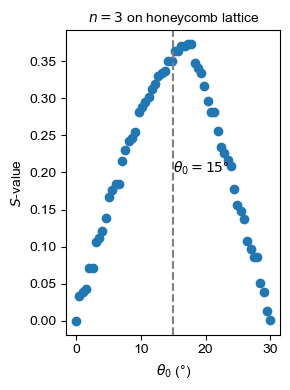

In [6]:
data_file = Path("subfigs-Fig6b/3P-angle-dep.npy")
angles = np.linspace(0, 30, 60)
if not data_file.exists():
    vmin_array = []
    for tht in angles:
        i_p, i_n = gen_zmesh_pn(
            rl_ratio=0.45,
            Rl_ratio=0.55,
            theta=tht,
            repeat=5,
            default_h=5 * nm,
            method=plot_3P_deposition,
        )
        shift, angle, vmin = grid_search_min_diff(
            i_p, i_n, w=200, search_range=50
        )
        vmin_array.append(vmin)
    vmin_array = np.array(vmin_array)
    np.save(data_file, vmin_array)
else:
    vmin_array = np.load(data_file)

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
ax.plot(angles, vmin_array, "o")
ax.set_xlabel("$\\theta_0$ (°)")
ax.set_ylabel("$S$-value")
ax.set_title("$n=3$ on honeycomb lattice")
ax.axvline(x=15, ls="--", color="gray")
ax.text(x=15, y=0.2, s="$\\theta_0=15$°", ha="left")
fig.tight_layout()
fig.savefig("subfigs-Fig6b/angle-deps-3P.png", dpi=300)

Next we draw the heatmap of S-value as a function of r/L and R/L values for honeycomb lattice.

In [7]:
data_file = Path("subfigs-Fig6b/min_array_honeycomb.npz")

if not data_file.exists():
    min_array = []
    r = np.linspace(0.10, 0.65, 32)
    R = np.linspace(0.10, 0.95, 32)
    rr, RR = np.meshgrid(r, R)
    min_array = []

    for r_, R_ in zip(rr.ravel(), RR.ravel()):
        i_p, i_n = gen_zmesh_pn(
            rl_ratio=r_, Rl_ratio=R_, theta=15, repeat=5, default_h=3 * nm
        )
        shift, angle, vmin = grid_search_min_diff(
            i_p, i_n, w=200, search_range=50
        )
        min_array.append(vmin)
    min_array = np.reshape(np.array(min_array), rr.shape)
    np.savez("min_array_honeycomb.npz", r=r, R=R, min_array=min_array)
else:
    data = np.load(data_file)
    r, R, min_array = data["r"], data["R"], data["min_array"]
    rr, RR = np.meshgrid(r, R)

imax = np.argmax(min_array)
opt_r, opt_R, opt_S = (
    rr.ravel()[imax],
    RR.ravel()[imax],
    min_array.ravel()[imax],
)
print(
    "Max position for honeycomb lattice:\n"
    "({0}, {1}) with S-value {2}".format(opt_r, opt_R, opt_S)
)

Max position for honeycomb lattice:
(0.45483870967741935, 0.6758064516129032) with S-value 0.4606027372839042


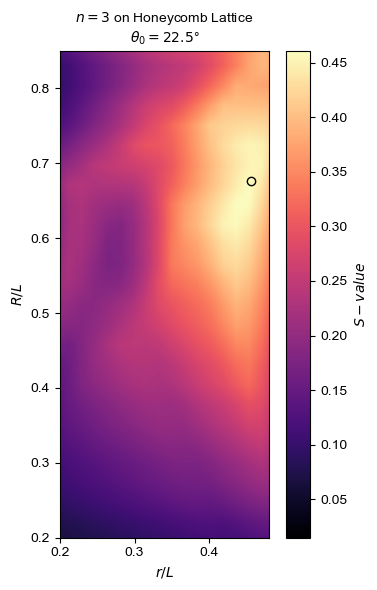

In [8]:
fig, ax = plt.subplots(1, 1, figsize=(4, 6))
cax = ax.imshow(
    min_array,
    origin="lower",
    extent=(rr.min(), rr.max(), RR.min(), RR.max()),
    cmap="magma",
)
ax.set_xlabel("$r/L$")
ax.set_ylabel("$R/L$")
ax.set_title("$n=3$ on Honeycomb Lattice\n$\\theta_0=22.5$°")
ax.plot(opt_r, opt_R, "o", markerfacecolor="none", markeredgecolor="k")
cbar = fig.colorbar(cax)
cbar.ax.set_ylabel("$S-value$")
ax.set_xlim(0.2, 0.48)
ax.set_ylim(0.2, 0.85)
fig.tight_layout()
fig.savefig("subfigs-Fig6b/phase-diagram-3P.png", dpi=300)

Plot the example deposition patterns

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

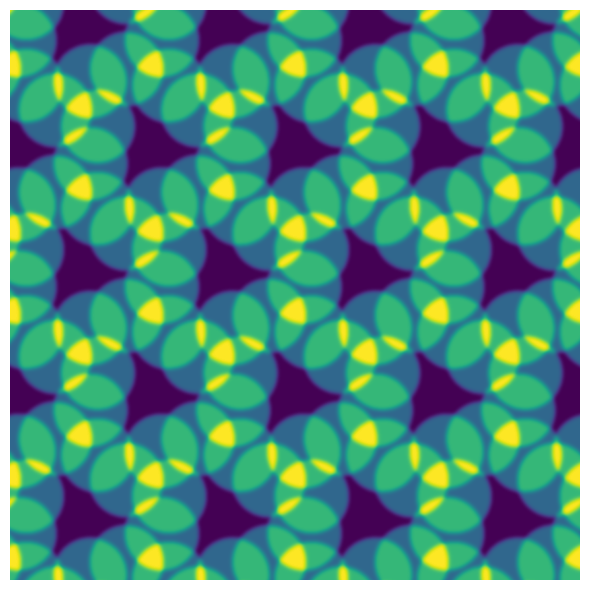

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for tht in [0, 5, 15, 25, 30]:
    system = plot_3P_deposition(
        plt.gca(),
        rl_ratio=0.45,
        Rl_ratio=0.63,
        theta=tht,
        diffusion=15 * nm,
        default_h=4 * nm,
        repeat=6,
        n_pts=3,
    )
    i_p, i_n = gen_zmesh_pn(
        rl_ratio=opt_r,
        Rl_ratio=opt_R,
        theta=tht,
        repeat=5,
        default_h=3 * nm,
        method=plot_3P_deposition,
    )
    shift, angle, vmin = grid_search_min_diff(i_p, i_n)
    fig.tight_layout()
    fig.savefig(f"subfigs-Fig6b/3P-deposition-angle-{tht}.png", dpi=300)

## Part II. Analysis for square systems (n=4)

Here we will analyze the dependency of the chirality index on the angle displacement \theta_0. Similar to the case of n=3 on honeycomb lattice, the maximal chirality is achieved when \theta_0 is close to half of the angle interval that the patterns becomes achiral

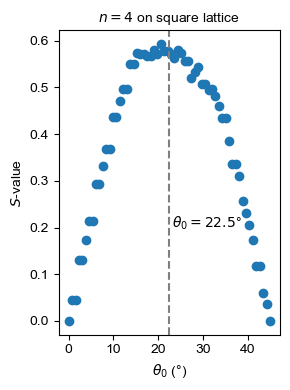

In [17]:
data_file = Path("subfigs-Fig6b/4P-angle-dep.npy")
angles = np.linspace(0, 45, 60)
if not data_file.exists():
    vmin_array = []
    for tht in angles:
        i_p, i_n = gen_zmesh_pn(
            rl_ratio=0.40,
            Rl_ratio=0.60,
            theta=tht,
            repeat=5,
            default_h=5 * nm,
            method=plot_4P_deposition,
        )
        shift, angle, vmin = grid_search_min_diff(
            i_p, i_n, w=200, search_range=50
        )
        vmin_array.append(vmin)
    vmin_array = np.array(vmin_array)
    np.save(data_file, vmin_array)
else:
    vmin_array = np.load(data_file)

fig, ax = plt.subplots(1, 1, figsize=(3, 4))
ax.plot(angles, vmin_array, "o")
ax.set_xlabel("$\\theta_0$ (°)")
ax.set_ylabel("$S$-value")
ax.set_title("$n=4$ on square lattice")
ax.axvline(x=22.5, ls="--", color="gray")
ax.text(x=23, y=0.2, s="$\\theta_0=22.5$°", ha="left")
fig.tight_layout()
fig.savefig("subfigs-Fig6b/angle-deps-4P.png", dpi=300)

Next we draw the heatmap of S-value as a function of r/L and R/L values for square lattice.

In [18]:
data_file = Path("subfigs-Fig6b/min_array_square.npz")
if not data_file.exists():
    min_array = []
    r = np.linspace(0.10, 0.48, 32)
    R = np.linspace(0.10, 0.85, 32)
    rr, RR = np.meshgrid(r, R)
    for r_, R_ in zip(rr.ravel(), RR.ravel()):
        i_p, i_n = gen_zmesh_pn(
            rl_ratio=r_,
            Rl_ratio=R_,
            theta=22.5,
            repeat=5,
            default_h=3 * nm,
            method=plot_4P_deposition,
        )
        shift, angle, vmin = grid_search_min_diff(
            i_p, i_n, w=200, search_range=50
        )
        min_array.append(vmin)

    min_array = np.reshape(np.array(min_array), rr.shape)
    np.savez("min_array_square.npz", r=r, R=R, min_array=min_array)
else:
    data = np.load(data_file)
    r, R, min_array = data["r"], data["R"], data["min_array"]
    rr, RR = np.meshgrid(r, R)

imax = np.argmax(min_array)
opt_r, opt_R, opt_S = (
    rr.ravel()[imax],
    RR.ravel()[imax],
    min_array.ravel()[imax],
)
print(
    "Max position for square lattice:\n"
    "({0}, {1}) with S-value {2}".format(opt_r, opt_R, opt_S)
)

Max position for square lattice:
(0.40645161290322585, 0.535483870967742) with S-value 0.5663123195373968


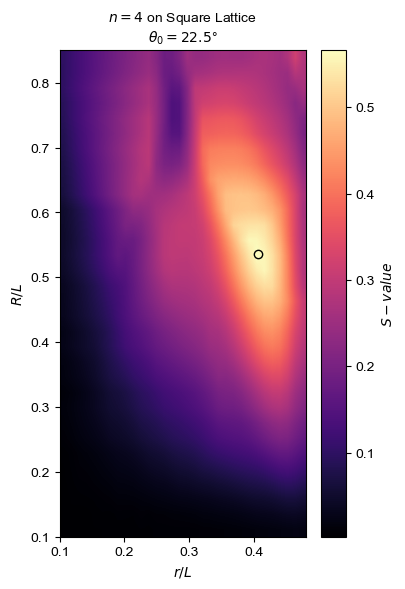

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(4, 6))
cax = ax.imshow(
    min_array,
    origin="lower",
    extent=(rr.min(), rr.max(), RR.min(), RR.max()),
    cmap="magma",
)
ax.set_xlabel("$r/L$")
ax.set_ylabel("$R/L$")
ax.set_title("$n=4$ on Square Lattice\n$\\theta_0=22.5$°")
ax.plot(
    rr.ravel()[imax],
    RR.ravel()[imax],
    "o",
    markerfacecolor="none",
    markeredgecolor="k",
)
cbar = fig.colorbar(cax)
cbar.ax.set_ylabel("$S-value$")
fig.tight_layout()
fig.savefig("subfigs-Fig6b/phase-diagram-4P.png", dpi=300)

Next plot the deposition patterns with different angles

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

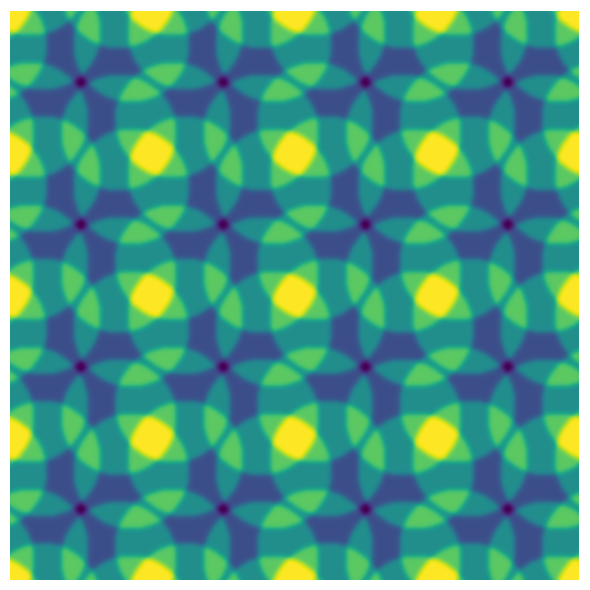

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
for tht in [0, 10, 22.5, 35, 45]:
    system = plot_4P_deposition(
        plt.gca(),
        rl_ratio=opt_r,
        Rl_ratio=opt_R,
        theta=tht,
        diffusion=10 * nm,
        default_h=4 * nm,
        repeat=6,
        n_pts=4,
    )
    i_p, i_n = gen_zmesh_pn(
        rl_ratio=opt_r,
        Rl_ratio=opt_R,
        theta=tht,
        repeat=5,
        default_h=3 * nm,
        method=plot_3P_deposition,
    )
    shift, angle, vmin = grid_search_min_diff(i_p, i_n)
    fig.tight_layout()
    fig.savefig(f"subfigs-Fig6b/4P-deposition-angle-{tht}.png", dpi=300)